# Identical prompt and query

Stephen Fleming

2025.03.26

The idea is to "snap" a cell to the manifold and see whether the output is similar to the input.

Use Mehrtash's branch `mb-cellarium-gpt-predict`

In [1]:
# !gsutil cp gs://cellarium-scratch/cellariumgpt_artifacts/pbmc_benchmark/pbmc_adata.h5ad \
#     /home/sfleming/data/assay_conversion/

In [1]:
import anndata
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
adata = anndata.read_h5ad('/home/sfleming/data/assay_conversion/pbmc_adata.h5ad')
adata

/home/sfleming/miniconda/envs/cellarium/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 30495 × 33694
    obs: 'NAME', 'nGene', 'nUMI', 'percent.mito', 'Cluster', 'CellType', 'Experiment', 'Method'
    var: 'gene_symbols'
    uns: 'CellType_colors', 'Method_colors'
    obsm: 'X_harmony'

In [3]:
from cellarium.ml.utilities.inference.cellarium_gpt_inference import CellariumGPTInferenceContext

In [4]:
adata.var

,gene_symbols
ENSG00000000003,TSPAN6
ENSG00000000005,TNMD
ENSG00000000419,DPM1
ENSG00000000457,SCYL3
ENSG00000000460,C1orf112
...,...
ENSG00000283096,RP11-157J13.1
ENSG00000283103,LLNLR-245B6.1
ENSG00000283117,CTD-2060L22.1
ENSG00000283118,RP11-107E5.4


In [5]:
adata.obs

,NAME,nGene,nUMI,percent.mito,Cluster,CellType,Experiment,Method
0,pbmc1_Celseq2_1_ACAGAC,3290,9030,0.0902547065337763,1,CD4+ T cell,pbmc1,CEL-Seq2
1,pbmc1_Celseq2_1_ACAGGA,2797,8482,0.116953548691346,1,CD4+ T cell,pbmc1,CEL-Seq2
2,pbmc1_Celseq2_1_ACGTTG,2651,6787,0.111978782967438,1,CD4+ T cell,pbmc1,CEL-Seq2
3,pbmc1_Celseq2_1_AGACCA,2766,6004,0.0932711525649567,1,CD4+ T cell,pbmc1,CEL-Seq2
4,pbmc1_Celseq2_1_CAACTC,3510,10162,0.11621728006298,1,CD4+ T cell,pbmc1,CEL-Seq2
...,...,...,...,...,...,...,...,...
30490,pbmc2_inDrops_1_TAGTCTCT.GAGCCTTA.ATCCGCTA,453,717,0.097629009762901,11,Plasmacytoid dendritic cell,pbmc2,inDrops
30491,pbmc2_inDrops_1_TCCAGAAG.TTATGCGA.TAAGACGG,592,938,0.035181236673774,11,Plasmacytoid dendritic cell,pbmc2,inDrops
30492,pbmc2_inDrops_1_TGAATCCT.GAGCCTTA.CCCAAGCA,406,662,0.138972809667674,11,Plasmacytoid dendritic cell,pbmc2,inDrops
30493,pbmc2_inDrops_1_TGAATCCT.TTATGCGA.CATCTCCC,1001,2066,0.0556631171345595,11,Plasmacytoid dendritic cell,pbmc2,inDrops


In [6]:
ctx = CellariumGPTInferenceContext(
    # cellarium_gpt_ckpt_path='/home/sfleming/trained_models/epoch=1-step=29161.ckpt',
    cellarium_gpt_ckpt_path='/home/sfleming/trained_models/epoch=6-step=63560.ckpt',
    ref_adata_path='/home/sfleming/data/extract_0.h5ad',
    gene_info_tsv_path='/home/sfleming/data/gene_info.tsv',
    device="cuda",
    attention_backend="mem_efficient",
    verbose=True,
)

In [7]:
adata_sub = adata[
    (adata.obs['Method'] == '10x Chromium (v3)')
    & (adata.obs['CellType'] == 'CD4+ T cell')
][:, adata.var_names.isin(ctx.model_var_names_set)].copy()
adata_sub.obs['total_mrna_umis'] = adata_sub.obs['nUMI'].astype(int)
adata_sub.obs['assay_ontology_term_id'] = 'EFO:0009922'  # 10x v3
adata_sub.obs['suspension_type'] = 'cell'
adata_sub.obs['cell_type_ontology_term_id'] = 'CL:0000624'  # CD4+ alpha-beta T cell
adata_sub.obs['tissue_ontology_term_id'] = 'UBERON:0000178'  # blood
adata_sub.obs['development_stage_ontology_term_id'] = None
adata_sub.obs['disease_ontology_term_id'] = None
adata_sub.obs['sex_ontology_term_id'] = None
adata_sub

AnnData object with n_obs × n_vars = 960 × 32351
    obs: 'NAME', 'nGene', 'nUMI', 'percent.mito', 'Cluster', 'CellType', 'Experiment', 'Method', 'total_mrna_umis', 'assay_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'sex_ontology_term_id'
    var: 'gene_symbols'
    uns: 'CellType_colors', 'Method_colors'
    obsm: 'X_harmony'

In [8]:
adata_sub.obs.head()

,NAME,nGene,nUMI,percent.mito,Cluster,CellType,Experiment,Method,total_mrna_umis,assay_ontology_term_id,suspension_type,cell_type_ontology_term_id,tissue_ontology_term_id,development_stage_ontology_term_id,disease_ontology_term_id,sex_ontology_term_id
6697,pbmc1_10x_v3_AAACCCACACTTGGGC,1860,6914,0.0911194677466011,1,CD4+ T cell,pbmc1,10x Chromium (v3),6914,EFO:0009922,cell,CL:0000624,UBERON:0000178,None,None,None
6698,pbmc1_10x_v3_AAACCCATCTTACACT,1758,6168,0.0856031128404669,1,CD4+ T cell,pbmc1,10x Chromium (v3),6168,EFO:0009922,cell,CL:0000624,UBERON:0000178,None,None,None
6699,pbmc1_10x_v3_AAAGAACAGCAGGCAT,2425,8265,0.0815486993345433,1,CD4+ T cell,pbmc1,10x Chromium (v3),8265,EFO:0009922,cell,CL:0000624,UBERON:0000178,None,None,None
6700,pbmc1_10x_v3_AAAGAACTCAAAGACA,1553,5789,0.0730696147866644,1,CD4+ T cell,pbmc1,10x Chromium (v3),5789,EFO:0009922,cell,CL:0000624,UBERON:0000178,None,None,None
6701,pbmc1_10x_v3_AAAGTCCGTAGGCAGT,2655,9163,0.0966932227436429,1,CD4+ T cell,pbmc1,10x Chromium (v3),9163,EFO:0009922,cell,CL:0000624,UBERON:0000178,None,None,None


In [10]:
adata_sub_sub = adata_sub[:, np.random.choice(adata_sub.shape[1], 4096, replace=False)].copy()
adata_sub_sub

AnnData object with n_obs × n_vars = 960 × 4096
    obs: 'NAME', 'nGene', 'nUMI', 'percent.mito', 'Cluster', 'CellType', 'Experiment', 'Method', 'total_mrna_umis', 'assay_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'sex_ontology_term_id'
    var: 'gene_symbols'
    uns: 'CellType_colors', 'Method_colors'
    obsm: 'X_harmony'

In [38]:
def batched_inference_query_equals_prompt_no_metadata(ctx, adata, batch_size: int = 8, summarize: str = 'mean'):

    gene_nq_list = []

    try:

        for ind in tqdm(range(0, len(adata), batch_size)):

            tokens_dict, context_indices = ctx.generate_tokens_from_adata(
                adata=adata,
                obs_index=np.arange(ind, min(len(adata), ind + batch_size)),
                query_var_names=adata.var_names,
                n_rand_prompt_vars=None,
                rand_prompt_var_names_sublist=None,
                fixed_prompt_var_names_sublist=None,
                rng=None,
                query_total_mrna_umis=None,
                metadata_prompt_masks_dict={  # do you want it to show up in the prompt
                    "cell_type": False,
                    "tissue": False,
                    "development_stage": False,
                    "disease": False,
                    "sex": False,
                },
            )

            with torch.no_grad():
                if summarize == 'mean':
                    gene_marginal_mean_nq, _ = ctx.get_marginal_mean_std_from_tokens(
                        tokens_dict=tokens_dict,
                        context_indices=context_indices,
                        use_logsumexp=True,
                        max_counts=500,
                    )
                    gene_nq_list.append(gene_marginal_mean_nq)
                elif summarize == 'sample':
                    gene_logits_nqk = ctx.get_gene_value_logits_from_tokens(
                        tokens_dict=tokens_dict,
                        context_indices=context_indices,
                        max_counts=500,
                    )
                    # sample from the logits
                    gene_sample_nq = torch.distributions.Categorical(logits=gene_logits_nqk).sample()
                    gene_nq_list.append(gene_sample_nq)
                else:
                    raise ValueError("summarize must be 'mean' or 'sample'")

    except KeyboardInterrupt:
        print("Interrupted by user")

    gene_nq = torch.cat(gene_nq_list, dim=0)
    return gene_nq

In [47]:
gene_marginal_mean_nq = batched_inference_query_equals_prompt_no_metadata(
    ctx, 
    adata_sub_sub, 
    batch_size=8,
    # summarize='mean',
    summarize='sample',
)

 52%|█████▎    | 63/120 [23:39<21:24, 22.53s/it]

Interrupted by user


In [48]:
gene_marginal_mean_nq.shape

torch.Size([504, 4096])

In [49]:
df = pd.DataFrame(
    {
        "raw_mean": np.array(adata_sub_sub.X.mean(axis=0)).squeeze(),
        "gpt_mean": gene_marginal_mean_nq.cpu().numpy().squeeze().mean(axis=0),
    },
    index=adata_sub_sub.var_names,
)
df['raw_mean_norm'] = df['raw_mean'] / df['raw_mean'].sum()
df['gpt_mean_norm'] = df['gpt_mean'] / df['gpt_mean'].sum()
df

,raw_mean,gpt_mean,raw_mean_norm,gpt_mean_norm
ENSG00000145545,0.015625,0.033730,0.000031,0.000060
ENSG00000268129,0.007292,0.011905,0.000015,0.000021
ENSG00000070367,0.060417,0.105159,0.000120,0.000188
ENSG00000173757,0.209375,0.228175,0.000417,0.000409
ENSG00000260808,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...
ENSG00000109118,0.180208,0.176587,0.000359,0.000316
ENSG00000241111,0.000000,0.001984,0.000000,0.000004
ENSG00000253112,0.000000,0.000000,0.000000,0.000000
ENSG00000115504,0.047917,0.067460,0.000095,0.000121


In [50]:
from scipy.stats import pearsonr

r = pearsonr(
    df["raw_mean_norm"].apply(lambda x: np.log10(x + 1e-6)), 
    df["gpt_mean_norm"].apply(lambda x: np.log10(x + 1e-6)),
).statistic

print(
    pearsonr(
        df["raw_mean_norm"].apply(lambda x: np.log10(x + 1e-6)), 
        df["gpt_mean_norm"].apply(lambda x: np.log10(x + 1e-6)),
    )
)

print(
    pearsonr(
        df["raw_mean_norm"], 
        df["gpt_mean_norm"],
    )
)

PearsonRResult(statistic=0.9254004962493037, pvalue=0.0)
PearsonRResult(statistic=0.9850337243586957, pvalue=0.0)


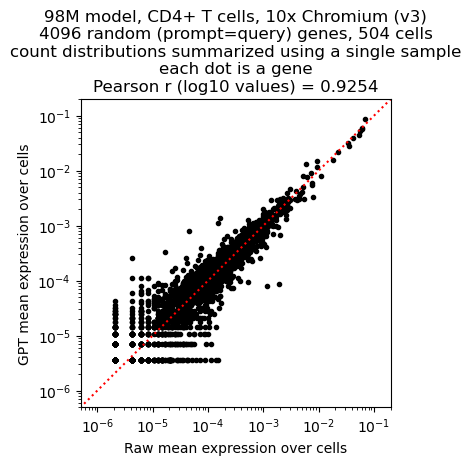

In [51]:
plt.figure(figsize=(4, 4))
plt.loglog(df["raw_mean_norm"], df["gpt_mean_norm"], 'k.')
plt.plot([0, 1], [0, 1], 'r:')
plt.ylim([5e-7, 2e-1])
plt.xlim([5e-7, 2e-1])
# plt.gca().axis('equal')
plt.xlabel("Raw mean expression over cells")
plt.ylabel("GPT mean expression over cells")
plt.title(f'98M model, CD4+ T cells, 10x Chromium (v3)\n'
          f'4096 random (prompt=query) genes, {gene_marginal_mean_nq.shape[0]} cells\n'
          f'count distributions summarized using a single sample\n'
          f'each dot is a gene\n'
          f'Pearson r (log10 values) = {r:.4f}')
plt.show()